## **Elaborazione di Immagini Mediche**
### Contest 2021/22 - Segmentazione ghiandola prostatica in immagini MRI




*   Collegamento a Google Drive e import delle librerie necessarie



In [ ]:
# Before running the script, reset the runtime to factory reset (Runtime -> Factory Reset Runtime)
# and then change runtime type to GPU (Runtime -> Change runtime type)

# Install libriary dependencies for running deep learning
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0 
!pip install plotly==5.3.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import plotly.express as px
import plotly.express as px

from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries

import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from segmentation_models import Unet

Mounted at /content/drive


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


*   Preparazione del dataset

In [ ]:
# Tip : eliminare una cartella non vuota all'interno di Colab
#!rm -rf <path_to_folder_name>  # inserire path della cartella da rimuovere

# Tip: per scaricare una o più cartelle da Colab occorre prima comprimerle in un
# unico archivio RAR
#!zip -r <file_zip> <path_to_folder_name>

In [ ]:
# Caricamento dataset in formato .rar da Google Drive a Colab
!pip install unrar
!unrar x "drive/MyDrive/EIM/Contest/DATASET_stu.rar"   # inserire path completa in cui si trovano i dati (es. "drive/MyDrive/..../DATASET_stu.rar")


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from drive/MyDrive/EIM/Contest/DATASET_stu.rar

Creating    DATASET_stu                                               OK
Creating    DATASET_stu/test                                          OK
Creating    DATASET_stu/test/images                                   OK
Extracting  DATASET_stu/test/images/2001.tiff                              1%  2%  OK 
Extracting  DATASET_stu/test/images/2022.tiff                              4%  OK 
Extracting  DATASET_stu/test/images/3032.tiff                              6%  OK 
Extracting  DATASET_stu/test/images/3068.tiff                              7%  8%  OK 
Extracting  DATASET_stu/test/images/3268.tiff                              9%  OK 
Extracting  DATASET_stu/test/images/MIP-PROSTATE-01-0002.tiff             11%  OK 
Extracting  DATASET_stu/test/images/MIP-PROSTATE-01-0008.tiff             13%

In [ ]:
# Creare la cartella che conterrà i risultati della rete nel test set
path_results = os.path.join("DATASET_stu","test","automatic")
os.mkdir(path_results)
path_results = os.path.join("DATASET_stu","train","automatic")
os.mkdir(path_results)
path_results = os.path.join("DATASET_stu","val","automatic")
os.mkdir(path_results)

In [ ]:
current_dir = '/content/'
dataset_name = 'DATASET_stu'

# Path
TRAIN_IMG_path = os.path.join(dataset_name,'train','images')
TRAIN_MASK_path = os.path.join(dataset_name,'train','manual')
VAL_IMG_path = os.path.join(dataset_name,'val','images')
VAL_MASK_path = os.path.join(dataset_name,'val','manual')

# Estrazione della lista di volumi del training e validation set
train_images = os.listdir(TRAIN_IMG_path)
val_images = os.listdir(VAL_IMG_path)

# Si vuole allenare una rete che prenda in ingresso un'immagine 512x512x3 (rgb) 
# e la rispettiva maschera di segmentazione (0:background, 255:lesione)
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
NUM_CLASSES = 2

In [ ]:
from skimage.color import gray2rgb

# Inizializzazioni matrici per il Training Set che conteranno le singole slice e le rispettive maschere.
X_train = np.zeros((len(train_images)*24,IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_images)*24,IMG_WIDTH,IMG_HEIGHT,NUM_CLASSES), dtype=np.float32)


 
for n, id_ in tqdm(enumerate(train_images), total=len(train_images)):

    # la variabile "n" rappresenta un contatore (0-num_immagini) mentre "id_" 
    # contiene il nome della n-esima immagine
    
    # Lettura immagine 
    img = imread(TRAIN_IMG_path+ "/" + id_ )
    for l in range(np.size(img,0)):

      #conversione dell'immagine in formato RGB e ricampionamento a 512x512
      img2 = gray2rgb(img[l,:,:])
      img2 = resize(img2,(512,512),preserve_range=True)

      #zooming dell'immagine
      X_train[(n*24)+l] = img2[128:384,128:384] 
    
    # Lettura maschera BW e ricampionamento maschera a 512x512
    mask = imread(TRAIN_MASK_path+ "/" +id_)
    for t in range(np.size(mask,0)):
      mask2 =  mask[t,:,:]
      mask2 = resize(mask2,(512,512),preserve_range=True)
      mask2 = to_categorical(mask2, num_classes=NUM_CLASSES, dtype='float32')

      #zooming della maschera
      Y_train[(n*24)+t] = mask2[128:384,128:384]


# Creazione matrici per validation set che conteranno le singole slice e le rispettive maschere.
X_val = np.zeros((len(val_images)*24,IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((len(val_images)*24,IMG_WIDTH,IMG_HEIGHT,NUM_CLASSES), dtype=np.float32)

for n, id_ in tqdm(enumerate(val_images), total=len(val_images)):
    # la variabile "n" rappresenta un contatore (0-num_immagini) mentre "id_" 
    # contiene il nome della n-esima immagine
    
    # Lettura immagine 
    img = imread(VAL_IMG_path+"/"+id_)
    for l in range(np.size(img,0)):

      #conversione dell'immagine in formato RGB e ricampionamento a 512x512
      img2 = gray2rgb(img[l,:,:]) 
      img2 = resize(img2,(512,512),preserve_range=True)

      #zooming dell'immagine
      X_val[(n*24)+l] = img2[128:384,128:384]

    # Lettura maschera BW e ricampionamento maschera a 512x512
    mask = imread(VAL_MASK_path+ "/" +id_)
    for t in range(np.size(mask,0)):
      mask2 =  mask[t,:,:]
      mask2 = resize(mask2,(512,512),preserve_range=True)
      mask2 = to_categorical(mask2, num_classes=NUM_CLASSES, dtype='float32')

      #zooming della maschera
      Y_val[(n*24)+t] = mask2[128:384,128:384]


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


361


(<matplotlib.image.AxesImage at 0x7f0421c35c10>,
 Text(0.5, 1.0, 'manual segmentation'))

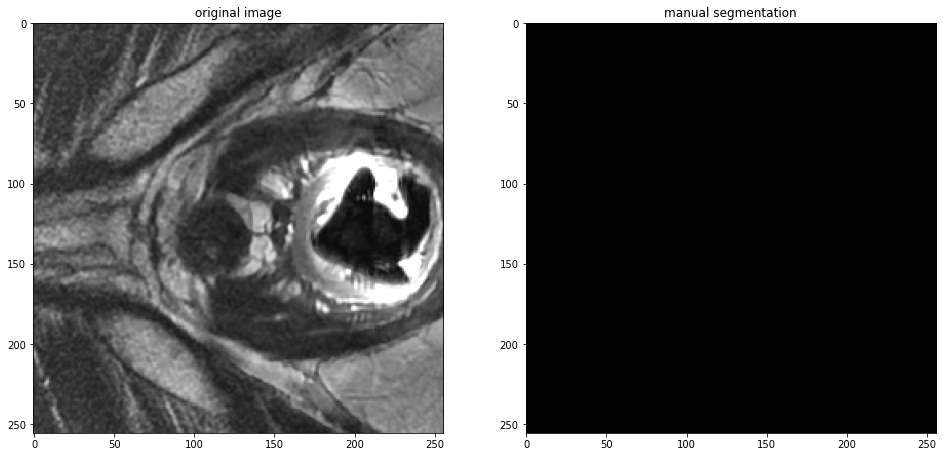

In [ ]:
# Estrazione di una casuale immagine di training 
random_index = random.randrange(1,768,1)

print(random_index)

fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_train[random_index],cmap=plt.cm.gray), ax1.set_title('original image')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(Y_train[random_index,:,:,1],cmap=plt.cm.gray), ax2.set_title('manual segmentation')


In [ ]:
# Data augmentation (training set)
image_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   horizontal_flip = False,
                                   vertical_flip = False,
                                   fill_mode='nearest'
                                   )
 



# Data augmentation (validation set)
val_datagen = ImageDataGenerator()



# Generator (NON TOCCARE LE RIGHE SOTTOSTANTI)
seed = 1
def XYaugmentGenerator(X1, y, seed, batch_size):
    genX1 = image_datagen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = image_datagen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield X1i[0], X2i[0]

In [ ]:
# Definizione del modello UNET
BACKBONE = 'resnet34'
model = Unet(backbone_name=BACKBONE,
            input_shape=[256,256,3],
            encoder_weights='imagenet', 
            encoder_freeze=False,
            decoder_block_type='transpose',
            classes=2,
            activation='sigmoid')

# Definizione algoritmo di ottimizzazione e funzione di loss
model.compile('Adam', loss='binary_crossentropy', metrics=['binary_accuracy']


85524480/85521592 [==============================] - 1s 0us/step


In [ ]:
# Parametri della rete
n_train_samples = 768 # numero delle immagini di train
n_val_samples = 192 # numero delle immagini di validation
batch_size = 32
n_epochs = 35

# Checkpoint definition
csv_logger = CSVLogger('./log.out', append=True, separator=';')
callbacks_list = [csv_logger]

# Train model
results = model.fit_generator(XYaugmentGenerator(X_train,Y_train,seed, batch_size), 
                              steps_per_epoch = np.ceil(float(len(X_train))/float(batch_size)),
                              validation_data = val_datagen.flow(X_val,Y_val,batch_size), 
                              validation_steps = np.ceil(float(len(X_val))/float(batch_size)),
                              shuffle = True,
                              epochs = n_epochs ,
                              callbacks = callbacks_list) 

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning:

NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (768, 256, 256, 2) (2 channels).



24/24 [==============================] - 39s 2s/step - loss: 0.0640 - binary_accuracy: 0.9844 - mean_io_u: 0.2585 - val_loss: 0.0649 - val_binary_accuracy: 0.9840 - val_mean_io_u: 0.2584
Epoch 2/70
24/24 [==============================] - 38s 2s/step - loss: 0.0592 - binary_accuracy: 0.9816 - mean_io_u: 0.2583 - val_loss: 0.1893 - val_binary_accuracy: 0.9591 - val_mean_io_u: 0.2583
Epoch 3/70
24/24 [==============================] - 38s 2s/step - loss: 0.0721 - binary_accuracy: 0.9783 - mean_io_u: 0.2582 - val_loss: 0.0789 - val_binary_accuracy: 0.9794 - val_mean_io_u: 0.2581
Epoch 4/70
24/24 [==============================] - 38s 2s/step - loss: 0.0381 - binary_accuracy: 0.9854 - mean_io_u: 0.2580 - val_loss: 0.0870 - val_binary_accuracy: 0.9767 - val_mean_io_u: 0.2580
Epoch 5/70
24/24 [==============================] - 38s 2s/step - loss: 0.0335 - binary_accuracy: 0.9858 - mean_io_u: 0.2579 - val_loss: 0.0643 - val_binary_accuracy: 0.9828 - val_mean_io_u: 0.2578
Epoch 6/70
24/24 [===

In [ ]:
#Salvataggio del modello allenato
model.save('modelloCONTEST')

In [ ]:
#Grafico dell'andamento di loss per il Training Set 

import matplotlib
import matplotlib.pyplot as plt

prova = results.history['loss']
x = range(35)

plt.plot(x,prova)

NameError: ignored

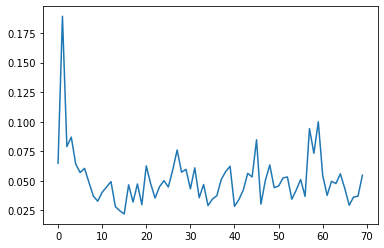

In [ ]:
#Grafico dell'andamento di loss per il Validation Set
prova2 = results.history['val_loss']
x = range(35)

plt.plot(x,prova2)